This makes sure the conda environment is installed and checks that GPU is accessible

In [2]:
# From https://datascience.stackexchange.com/questions/75948/how-to-setup-and-run-conda-on-google-colab
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:08
🔁 Restarting kernel...


In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
!conda install pytorch torchvision pytorch-cuda=11.8 -c pytorch -c nvidia
!pip install supervision tqdm ultralytics ipdb torchreid scikit-learn

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pytorch
    - pytorch-cuda=11.8
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    blas-2.116                 |              mkl          13 KB  conda-forge
    blas-devel-3.9.0           |   16_linux64_mkl          12 KB  conda-forge
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    cuda-cudart-11.8.89     

In [2]:
import torch
if not torch.cuda.is_available():
    print("E: GPU not available")
else:
    print("GPU available")


GPU available


In [ ]:
# Export environment, but unfortunately while recreating it, pytorch was throwing errors
!conda env export > environment.yml

Actual code to count people is below. If running on a separate environment, only the code below is necessary.

In [3]:
from pathlib import Path
import os

import cv2

def count_frames(video_path: os.PathLike | str) -> int:
    """Count the number of frames in a video file."""

    # Open the video file
    video_path = Path(video_path).as_posix()
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        print("E: Could not open video in {video_path}.")
        return

    # Get the total number of frames in the video
    total_n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    cap.release()

    return total_n_frames

In [8]:
from collections import defaultdict
import numpy as np
import supervision as sv
from ultralytics import YOLO
import torch
import torchreid
import torchvision
from tqdm.notebook import tqdm


VIDEO_PATH = "/content/People_Counting_Short_Assignment.mp4"

# Models
object_detector = YOLO("yolov8x.pt")
tracker = sv.ByteTrack()
reid_model = torchreid.models.osnet.osnet_x0_75()
reid_model.eval()
reid_model.training = False

# For visualization
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator(position=sv.Position.BOTTOM_CENTER)

pbar = tqdm(total=count_frames(VIDEO_PATH), desc="Processing frames")

id2embedding: dict[int, torch.Tensor] = {}
id2framecount: dict[int, int] = defaultdict(int)

def callback(frame: np.ndarray, frame_n: int) -> np.ndarray:
    pbar.update(1)

    # Run object detector
    results = object_detector(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Only track people
    detections = detections[detections.class_id == 0]  # 0 = YOLO's person class

    if len(detections) == 0:  # no person detected
        return frame

    # Inform tracker of person detections in the new frame
    detections = tracker.update_with_detections(detections)

    # For viz purposes
    labels = [
        f"Person pseudoID #{tracker_id}"
        for tracker_id in detections.tracker_id
    ]

    if len(labels) == 0:
        # Some frames might have detections but tracker might not have
        # initiallized any track yet
        return frame


    for detection in detections:
        xyxy, mask, confidence, class_id, tracker_id, data = detection
        cropped_person = sv.crop_image(frame, xyxy)

        # HWC -> BCHW and resize to rectangle
        crop_tensor = torch.from_numpy(cropped_person).detach().permute(2, 0, 1).to(dtype=torch.float)
        crop_tensor = crop_tensor.unsqueeze(0)
        crop_tensor = torchvision.transforms.functional.resize(crop_tensor, (200, 100))

        reid_embedding = reid_model(crop_tensor).detach().squeeze().flatten()

        # Running mean embedding for every tracklet
        id2framecount[tracker_id] += 1
        if tracker_id not in id2embedding:
            id2embedding[tracker_id] = reid_embedding
        else:
            T = id2framecount[tracker_id]
            id2embedding[tracker_id] = (1/T)*(reid_embedding + (T-1)*id2embedding[tracker_id])

    # Draw bbox, ID, and trace that follows the person walking
    annotated_frame = box_annotator.annotate(frame,
                                             detections=detections)
    annotated_frame = label_annotator.annotate(annotated_frame,
                                               detections=detections,
                                               labels=labels)
    annotated_frame = trace_annotator.annotate(annotated_frame,
                                               detections=detections)

    return annotated_frame

sv.process_video(
    source_path=VIDEO_PATH,
    target_path="viz.mp4",  # Save video with annotated tracks for sanity check
    callback=callback
)

pbar.close()

print(f"Number of tracks: {len(id2embedding)}")


Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_x0_75_imagenet.pth"


Processing frames:   0%|          | 0/1090 [00:00<?, ?it/s]

Number of people counted: 41


In [18]:
import gc
gc.collect()

362

Want to visualize the embeddings to see if different IDs have different embeddings or to see if the tracker messed it up

In [11]:
from sklearn.manifold import TSNE

## Dimensionality reduction
X = torch.stack(tuple(id2embedding.values())).detach()
print(f"{X.shape=}")

tsne_X = TSNE(n_components=2, perplexity=2).fit_transform(X)
labels = list(id2embedding.keys())

print(f"{tsne_X.shape=}")


X.shape=torch.Size([41, 512])
tsne_X.shape=(41, 2)


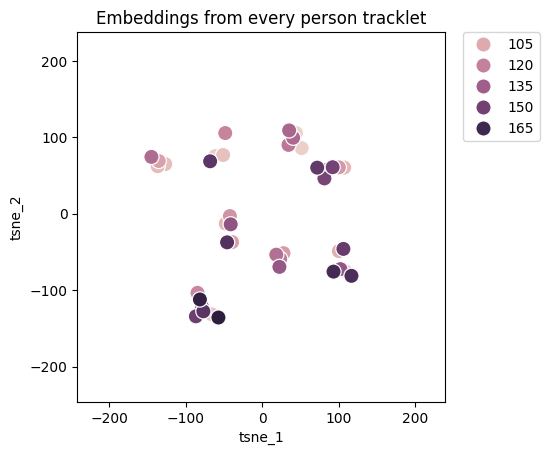

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# Plotting
tsne_result_df = pd.DataFrame({'tsne_1': tsne_X[:,0], 'tsne_2': tsne_X[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_X.min()-500, tsne_X.max()+500)
ax.set_xlim((tsne_X[:,0].mean()-3*tsne_X[:,0].std(), tsne_X[:,0].mean()+3*tsne_X[:,0].std()))
ax.set_ylim((tsne_X[:,1].mean()-3*tsne_X[:,1].std(), tsne_X[:,1].mean()+3*tsne_X[:,1].std()))
ax.set_aspect('equal')
ax.set_title("Embeddings from every person tracklet")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [40]:
import sklearn.cluster

n_clusters = len(set(sklearn.cluster.OPTICS().fit(X).labels_))

print(f"Number of people: {n_clusters}")

Number of people: 6
